In [1]:
import pygmt 
import pandas as pd 
import geopandas as gpd
import numpy as np
import os
import xarray as xr
import glob
from obspy import UTCDateTime

In [2]:
# 计算射线路径
def read_station(stafile):
    stations = pd.read_csv(stafile,sep='\s+',names=['station','latitude','longitude','elevation'])
    sta_dict = {}
    for i in range(len(stations)):
        staline = stations.iloc[i]
        station = staline['station']
        latitude = staline['latitude']
        longitude = staline['longitude']
        elevation = staline['elevation']
        sta_dict[station] = {'latitude':latitude,'longitude':longitude,'elevation':elevation}
    return sta_dict,stations
def read_pha(phafile,stafile):
    sta_dict,sta_df = read_station(stafile)
    catalog = []
    raypath = []
    with open(phafile,'r') as fp:
        for line in fp:
            tmp = line.split()
            if tmp[0] == "#":
                flag,year,month,day,hour,minute,second,lat,lon,dep,mag,eh,ez,rms,evtid = line.split()
                head = line
                time = UTCDateTime(int(year),int(month),int(day),int(hour),int(minute),0,0)+float(second)
                catalog.append([evtid,float(lon),float(lat),float(dep),float(mag),time])
            else:
                sta,tt,weight,phase_hint = line.split()
                sta = sta.upper()
                if sta in list(sta_dict):
                    stlo,stla,stel = sta_dict[sta]['longitude'],sta_dict[sta]['latitude'],sta_dict[sta]['elevation']
                    raypath.append([evtid,float(lat),float(lon),float(dep),float(mag),sta,stla,stlo,stel,phase_hint])
                else:
                    print(sta,' not in the station file')
    raypath_df = pd.DataFrame(data=raypath,columns=['evtid','evla','evlo','evdp','magnitude','station','stla','stlo','stel','phase_hint'])
    catalog_df = pd.DataFrame(catalog,columns=['evtid','longitude','latitude','depth','magnitude','time'])
    return catalog_df,raypath_df,sta_df

In [3]:
InputData = 'TGR_data//tomoDD09//ph2dt'
stafile = InputData+os.sep+'station.dat'
phafile = InputData+os.sep+'new_original.dat'
phafile = InputData+os.sep+'new.dat'
catalog_df,raypath_df,sta_df = read_pha(phafile, stafile)

In [4]:
# read mod
model = xr.open_dataset('TGR_data'+os.sep+'tomoDD09'+os.sep+'TGR_2009_velocity_3_19.h5')
grid_x,grid_y,grid_z = model.longitude.values,model.latitude.values,model.depth.values
grid_xy = np.meshgrid(grid_x,grid_y)
grid_xz = np.meshgrid(grid_x,grid_z)
grid_zy = np.meshgrid(grid_z,grid_y)

In [5]:
ray_xy_p = []
ray_xy_s = []
ray_xz_p = []
ray_xz_s = []
ray_yz_p = []
ray_yz_s = []
for i in range(len(raypath_df)):
    line = raypath_df.iloc[i]
    evla,evlo,evdp,stla,stlo,stel = line.evla,line.evlo,line.evdp,line.stla,line.stlo,line.stel
    phase_hint = line.phase_hint
    xy = "%9.4f %8.4f\n%9.4f %8.4f\n>\n"%(evlo,evla,stlo,stla)
    xz = "%9.4f %5.2f\n%9.4f %5.2f\n>\n"%(evlo,evdp,stlo,stel)
    yz = "%5.2f %9.4f\n%5.2f %9.4f\n>\n"%(evdp,evla,stel,stla)
    if phase_hint == 'P':
        ray_xy_p.append(xy)
        ray_xz_p.append(xz)
        ray_yz_p.append(yz)
    else:
        ray_xy_s.append(xy)
        ray_xz_s.append(xz)
        ray_yz_s.append(yz)

In [6]:
with open('raypath_xy_p.gmt','w') as fp:
    fp.writelines(ray_xy_p)
with open('raypath_xy_s.gmt','w') as fp:
    fp.writelines(ray_xy_s)
with open('raypath_xz_p.gmt','w') as fp:
    fp.writelines(ray_xz_p)
with open('raypath_xz_s.gmt','w') as fp:
    fp.writelines(ray_xz_s)
with open('raypath_yz_p.gmt','w') as fp:
    fp.writelines(ray_yz_p)
with open('raypath_yz_s.gmt','w') as fp:
    fp.writelines(ray_yz_s)

In [7]:
def plot_stratum(fig):
    fig.plot(data='TGR_data/geology/Permian.gmt',pen='0.1p',fill='247/207/138',close=True)
    fig.plot(data='TGR_data/geology/Triassic.gmt',pen='0.1p',fill='240/191/212',close=True)
    fig.plot(data='TGR_data/geology/Permian_sub.gmt',pen='0.1p',fill='247/207/138',close=True)
    fig.plot(data='TGR_data/geology/Presinian.gmt',pen='0.1p',fill='240/143/117',close=True)
    fig.plot(data='TGR_data/geology/Jurassic.gmt',pen='0.1p',fill='181/204/227',close=True)
def plot_H4909(fig):
    # read the geological data
    file = 'TGR_data/geology/H4909.gpkg'
    H4909 = gpd.read_file(file, layer='strata').set_crs('EPSG:4326')
    faults = gpd.read_file(file, layer='faults_main').set_crs('EPSG:4326')
    # 清洗数据
    geology = H4909.copy()
    for i in range(len(H4909)):
        data = H4909.iloc[i]
        if data.geometry.is_empty:
            geology = geology.drop(index=i)
    geo_categories = {'Q':{'name':'Q','label':'Q','color':'255/248/128'},
                    'K':{'name':'K','label':'K','color':'128/207/92'},
                    'J':{'name':'J','label':'J','color':'51/189/233'},
                    'T':{'name':'T','label':'T','color':'138/62/164'},
                    'P':{'name':'P','label':'P-Cm','color':'231/77/64'},
                    'Pt':{'name':'Pt','label':'Presinian','color':'240/143/117'}}
    geo_categories = {'Q':{'name':'Q','label':'Quaternary','color':'255/248/128'},
                    'K':{'name':'K','label':'Cretaceous','color':'128/207/92'},
                    'J':{'name':'J','label':'Jurassic','color':'181/204/227'},
                    'P':{'name':'P','label':'Permian-Cambrian','color':'247/207/138'},
                    'T':{'name':'T','label':'Triassic','color':'240/191/212'},
                    'Pt':{'name':'Pt','label':'Precambrian','color':'240/143/117'}}
    for i,name in enumerate(list(geo_categories)):
        array = geology[geology.DSO == name]
        color = geo_categories[name]['color']
        label = geo_categories[name]['label']
        fig.plot(data=array,pen='0.1p',fill=color,close=True)

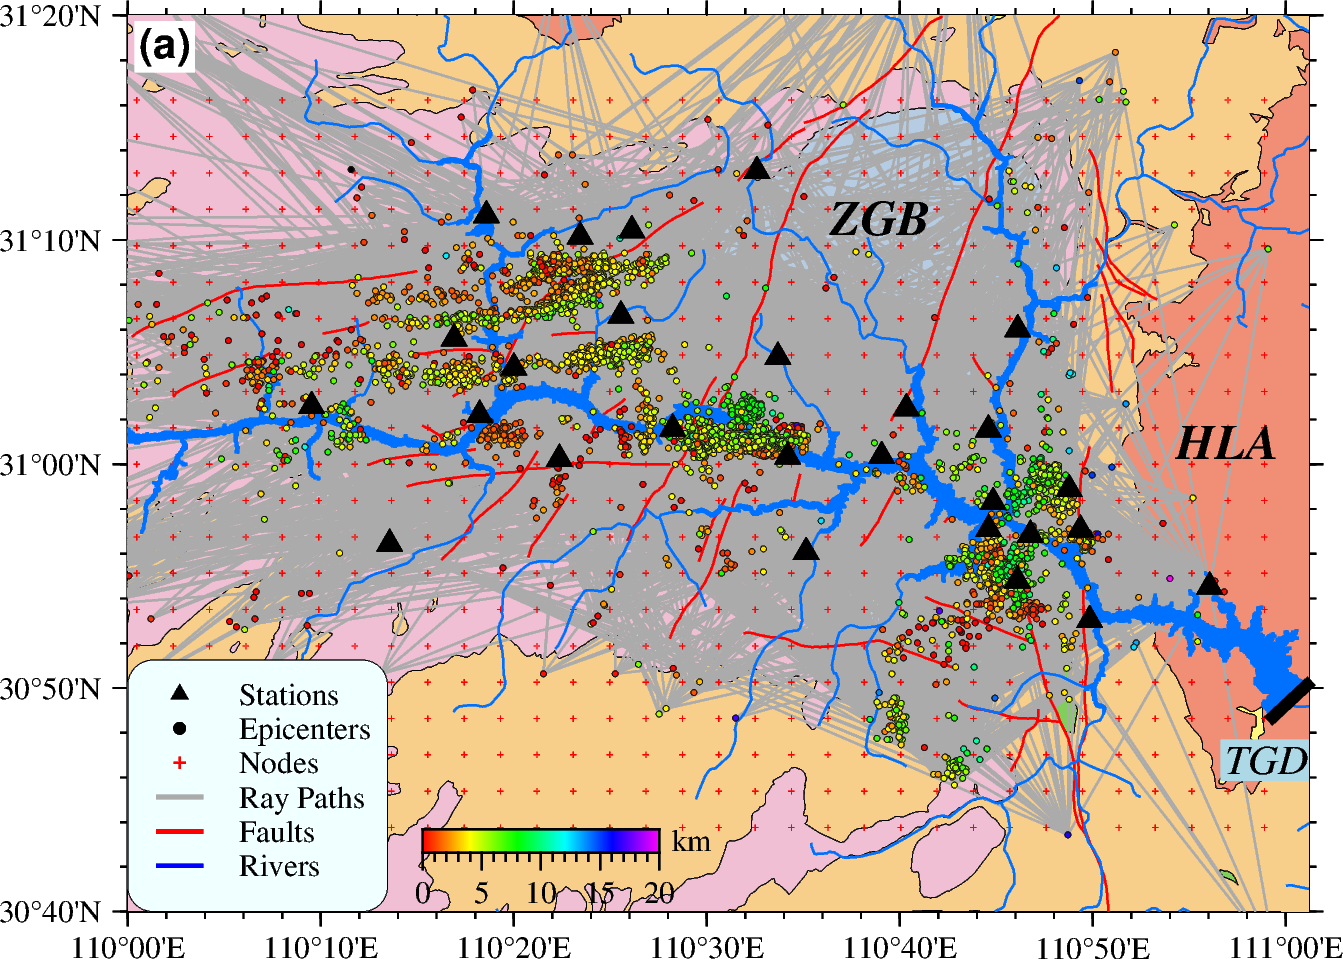

In [8]:
# plot
lon1,lon2,lat1,lat2,dep1,dep2 = [110,111.02,30+40/60,31+20/60,0,20]
region = [lon1,lon2,lat1,lat2]
fig = pygmt.Figure()
pygmt.config(FONT='7.5p,4',MAP_FRAME_TYPE='plain',MAP_FRAME_PEN='0.5p')
fig.basemap(region=region,projection='M10c',frame=['af','WSen'])
with pygmt.clib.Session() as session:
    with pygmt.helpers.GMTTempFile() as tmpfile:
        session.call_module("mapproject", f"-Wh ->{tmpfile.name}")
        map_height = tmpfile.read().strip()
map_height = float(map_height)

# plot the stratum
plot_H4909(fig)

# raypath
fig.plot(data='raypath_xy_p.gmt', pen="0.5p,171")
fig.plot(x=grid_xy[0].flatten(),y=grid_xy[1].flatten(),style='+0.02i',pen='0.2p,red')

# plot the faults
fig.plot(data='TGR_data/geology/Faults.gmt',pen='0.5p,red')

# plot the rivers
fig.plot(data='TGR_data/geology/Rivers.gmt',pen='0.5p,0/112/255',close=False) # Yangtze river
fig.plot(data='TGR_data/geology/TGR.shp',pen='0.5p,0/112/255',fill='0/112/255',close=False)

# mark the location of TGR
fig.plot(data=[[111.00376,30.823633,43,0.5,0.1]],style='j',fill='black',no_clip=True)
fig.text(x=111.00376,y=30.823633,text='TGD',font='10p,6,black',justify='MC',offset='-0.2c/-0.5c',fill='lightblue')
# mark the ZGB and HLA
fig.text(x=110+39/60,y=31+11/60,text='ZGB',font='12p,7,black',justify='MC')
fig.text(x=110+57/60,y=31+1/60,text='HLA',font='12p,7,black',justify='MC')

# plot the earthquakes
pygmt.makecpt(cmap='rainbow',series=[0,20,0.1],continuous=True,reverse=True)
fig.plot(x=catalog_df.longitude,y=catalog_df.latitude,style='c0.05c',cmap=True,pen='0.1p,20',fill=catalog_df.depth)
fig.colorbar(position='x2.5c/0.5c+w2.0c/0.2c+h',cmap=True,frame=['xaf','y+lkm'])
# plot the stations
fig.plot(x=sta_df.longitude,y=sta_df.latitude,style='t0.1i',fill='black',pen='0.1p,black')
with open('legend.gmt','w') as fp:
    lines = ['#H 12 Times-Roman Legend\n',
             'S 0.3c t 0.1c 0/0/0 	    1p,black 	0.8c Stations\n',
             'S 0.3c c 0.1c black 	    0.1p,black 	0.8c Epicenters\n',
             'S 0.3c + 0.1c - 	        0.5p,red 	0.8c Nodes\n',
             'S 0.3c - 0.4c 171 	    1p,171 		0.8c Ray Paths\n',
             'S 0.3c - 0.4c 255/0/0 	1p,red 		0.8c Faults\n',
             'S 0.3c - 0.4c 0/255/0 	1p,blue 	0.8c Rivers\n',
             'G 0.1c\n'
    ]
    fp.writelines(lines)
fig.legend(spec='legend.gmt',position='jBL+w2.2c',box='+gazure1+p0.1p+r')
fig.text(position='cTL',text='(a)',font='10p,1',offset='j0.1c/0.1c',fill='white')

# profile
# A1-A2
lonA1,latA1 = 110.237923, 31.2254903
lonA2,latA2 = 110.970744, 30.8196086
#fig.plot(x=[lonA1,lonA2],y=[latA1,latA2],pen='0.5p')
#fig.text(x=lonA1,y=latA1,text='A1',offset='-0.1i/-0.1i',fill='white')
#fig.text(x=lonA2,y=latA2,text='A2',offset='-0.1i/-0.05i',fill='white')

# B1-B2
lonB1,latB1 = 110.029215, 31.0899
lonB2,latB2 = 110.971183, 31.0899
#fig.plot(x=[lonB1,lonB2],y=[latB1,latB2],pen='0.5p')
#fig.text(x=lonB1,y=latB1,text='B1',offset='+0.0i/-0.1i',fill='white')
#fig.text(x=lonB2,y=latB2,text='B2',offset='-0.1i/-0.1i',fill='white')

fig.show()

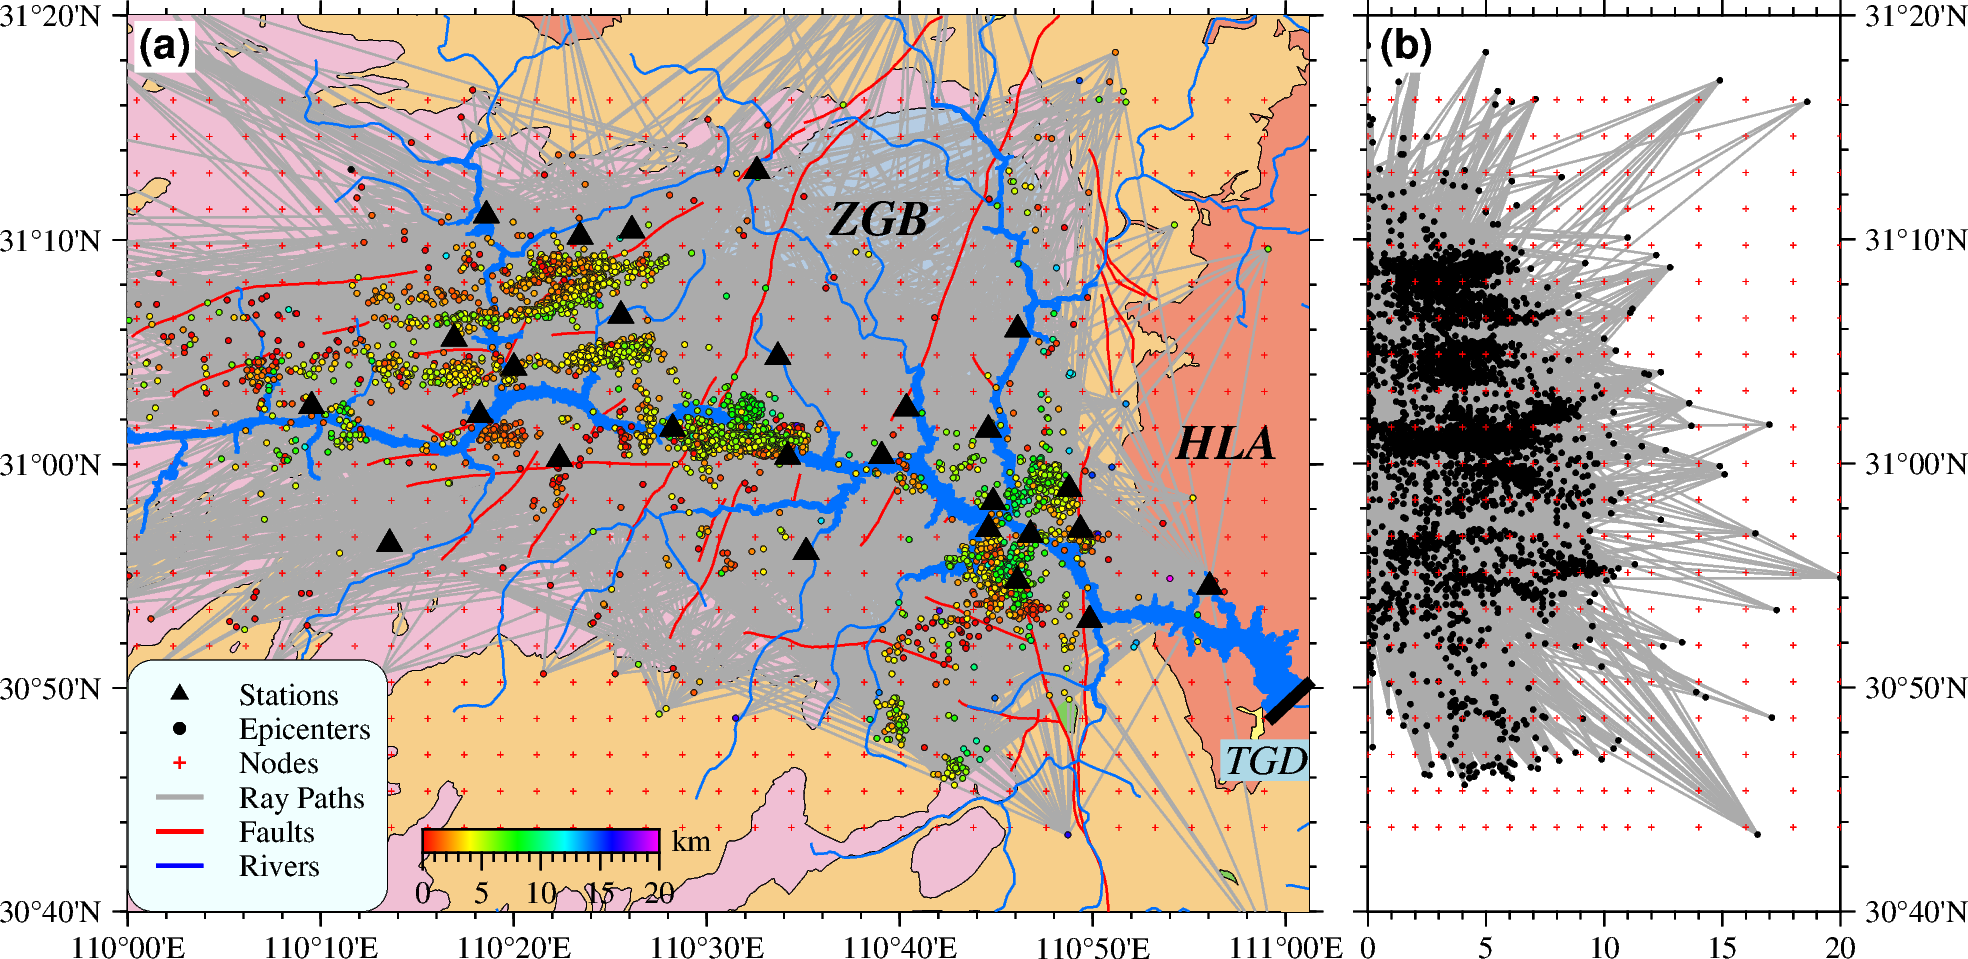

In [9]:
# yz
fig.shift_origin(xshift='10.5c')
fig.basemap(region=[dep1,dep2,lat1,lat2],projection='X4c/{}cd'.format(map_height),frame=['xaf','yaf','wSEn'])
fig.plot(data='raypath_yz_p.gmt', pen="0.5p,171")
fig.plot(x=catalog_df.depth,y=catalog_df.latitude,style='c0.05c',fill='black')
fig.plot(x=grid_zy[0].flatten(),y=grid_zy[1].flatten(),style='+0.02i',pen='0.2p,red')
fig.text(position='cTL',text='(b)',font='10p,1',offset='j0.1c/0.1c',fill='white')
fig.show()

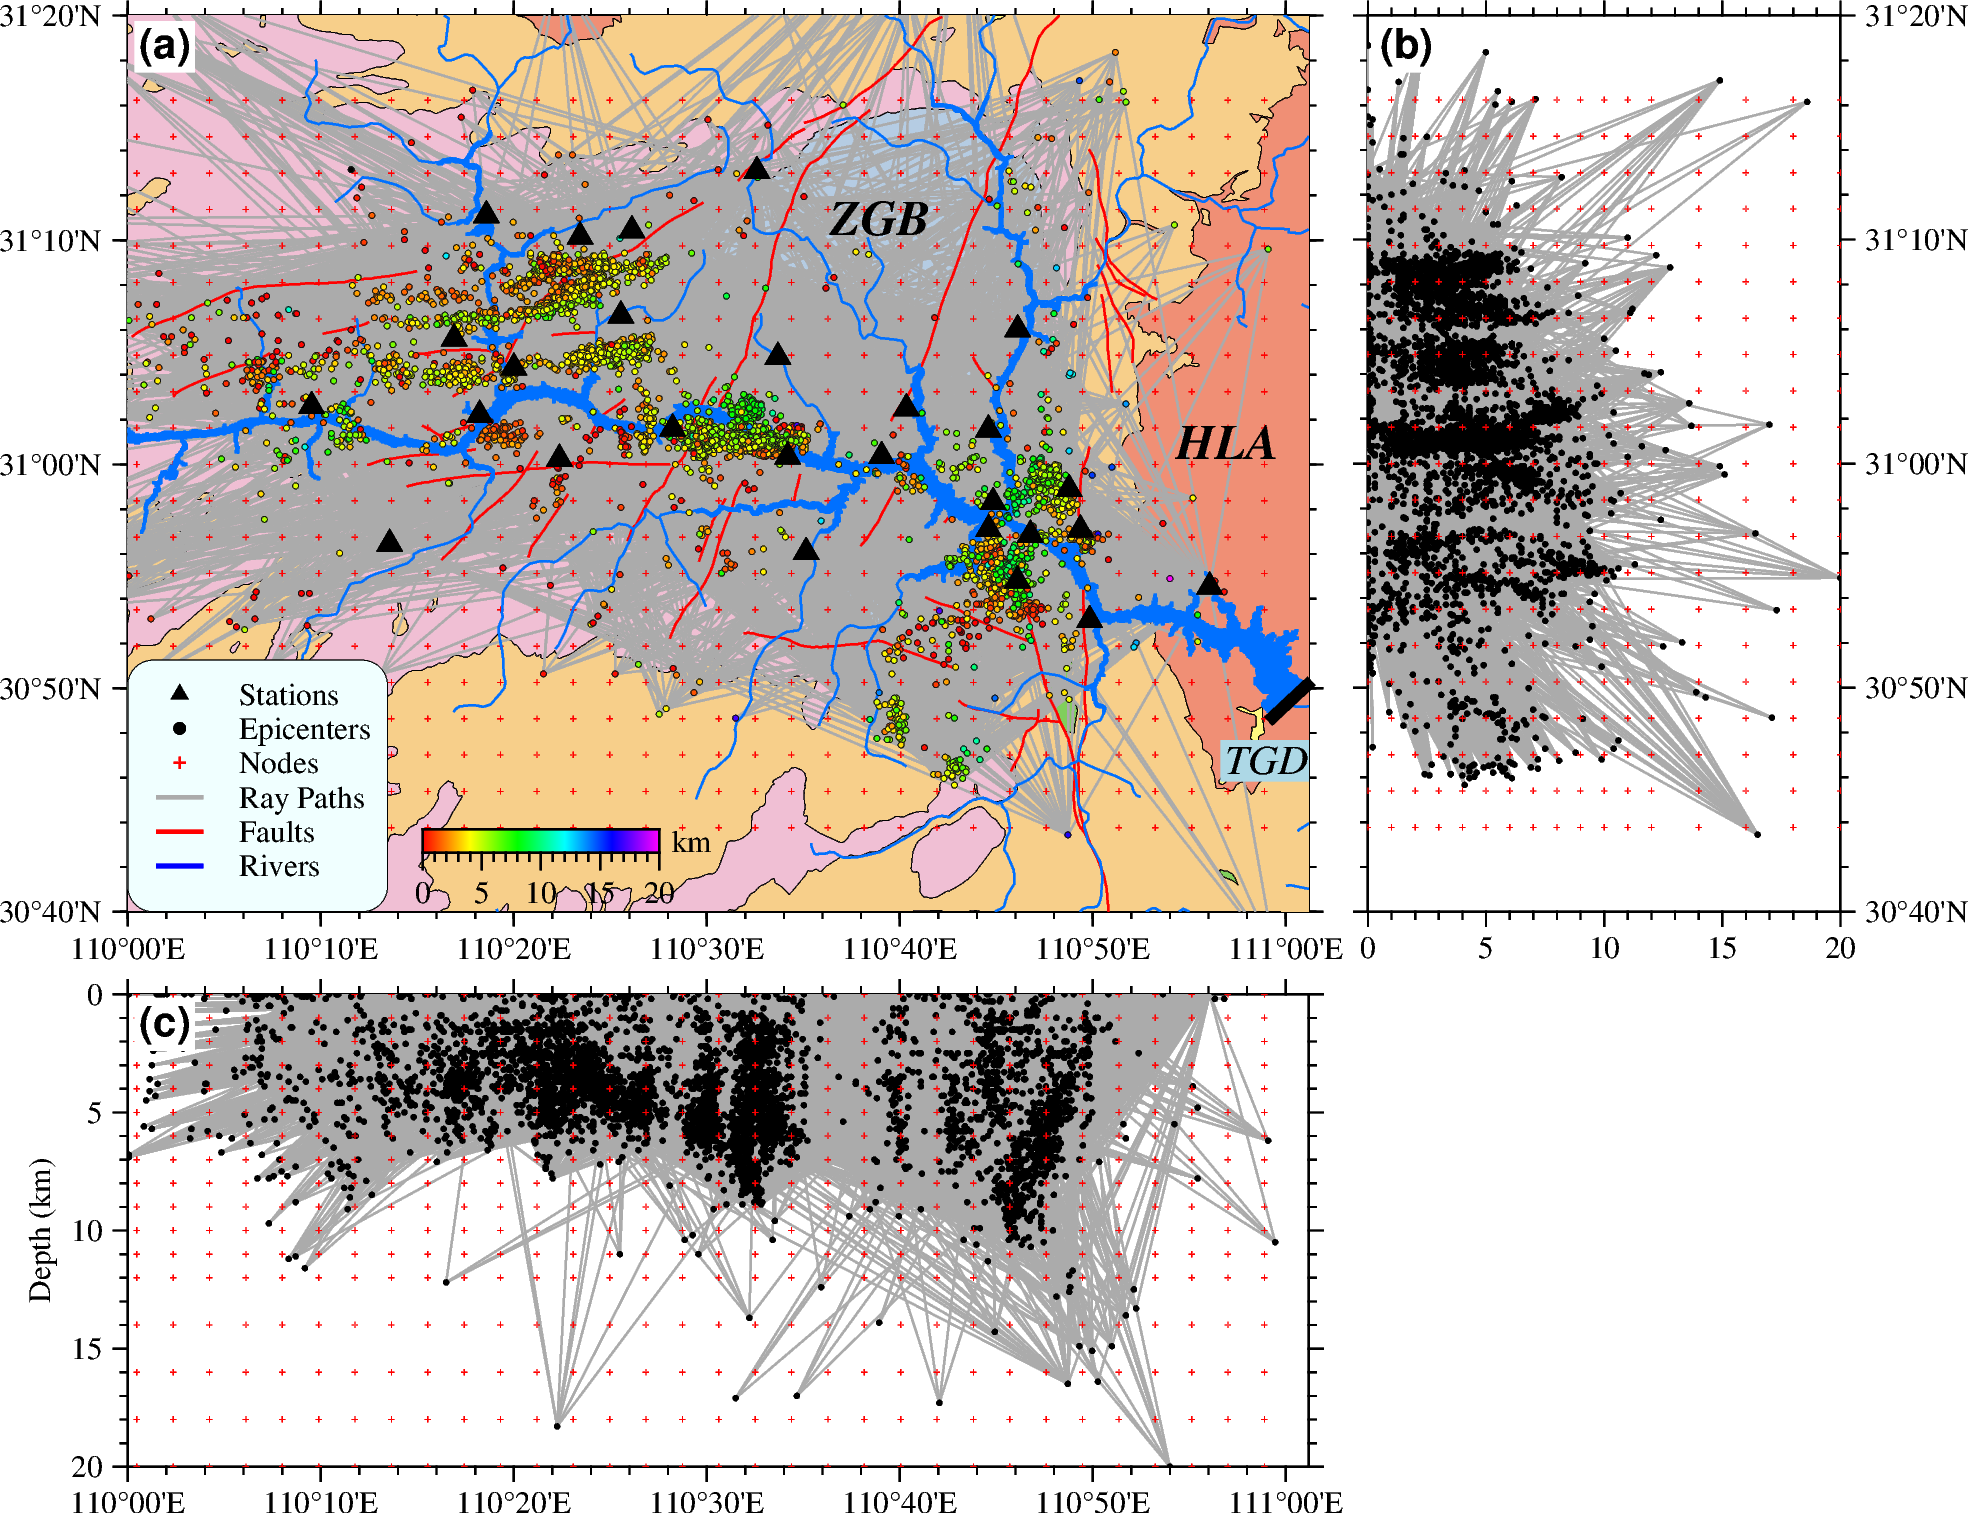

In [10]:
# xz
fig.shift_origin(xshift='-10.5c',yshift='-4.7c')
fig.basemap(region=[lon1,lon2,dep1,dep2],projection='X10cd/-4c',frame=['xaf','yaf+lDepth (km)','WSen'])
fig.plot(data='raypath_xz_p.gmt', pen="0.5p,171")
fig.plot(x=catalog_df.longitude,y=catalog_df.depth,style='c0.05c',fill='black')
fig.plot(x=grid_xz[0].flatten(),y=grid_xz[1].flatten(),style='+0.02i',pen='0.2p,red')
fig.text(position='cTL',text='(c)',font='10p,1',offset='j0.1c/0.1c',fill='white')
fig.show()

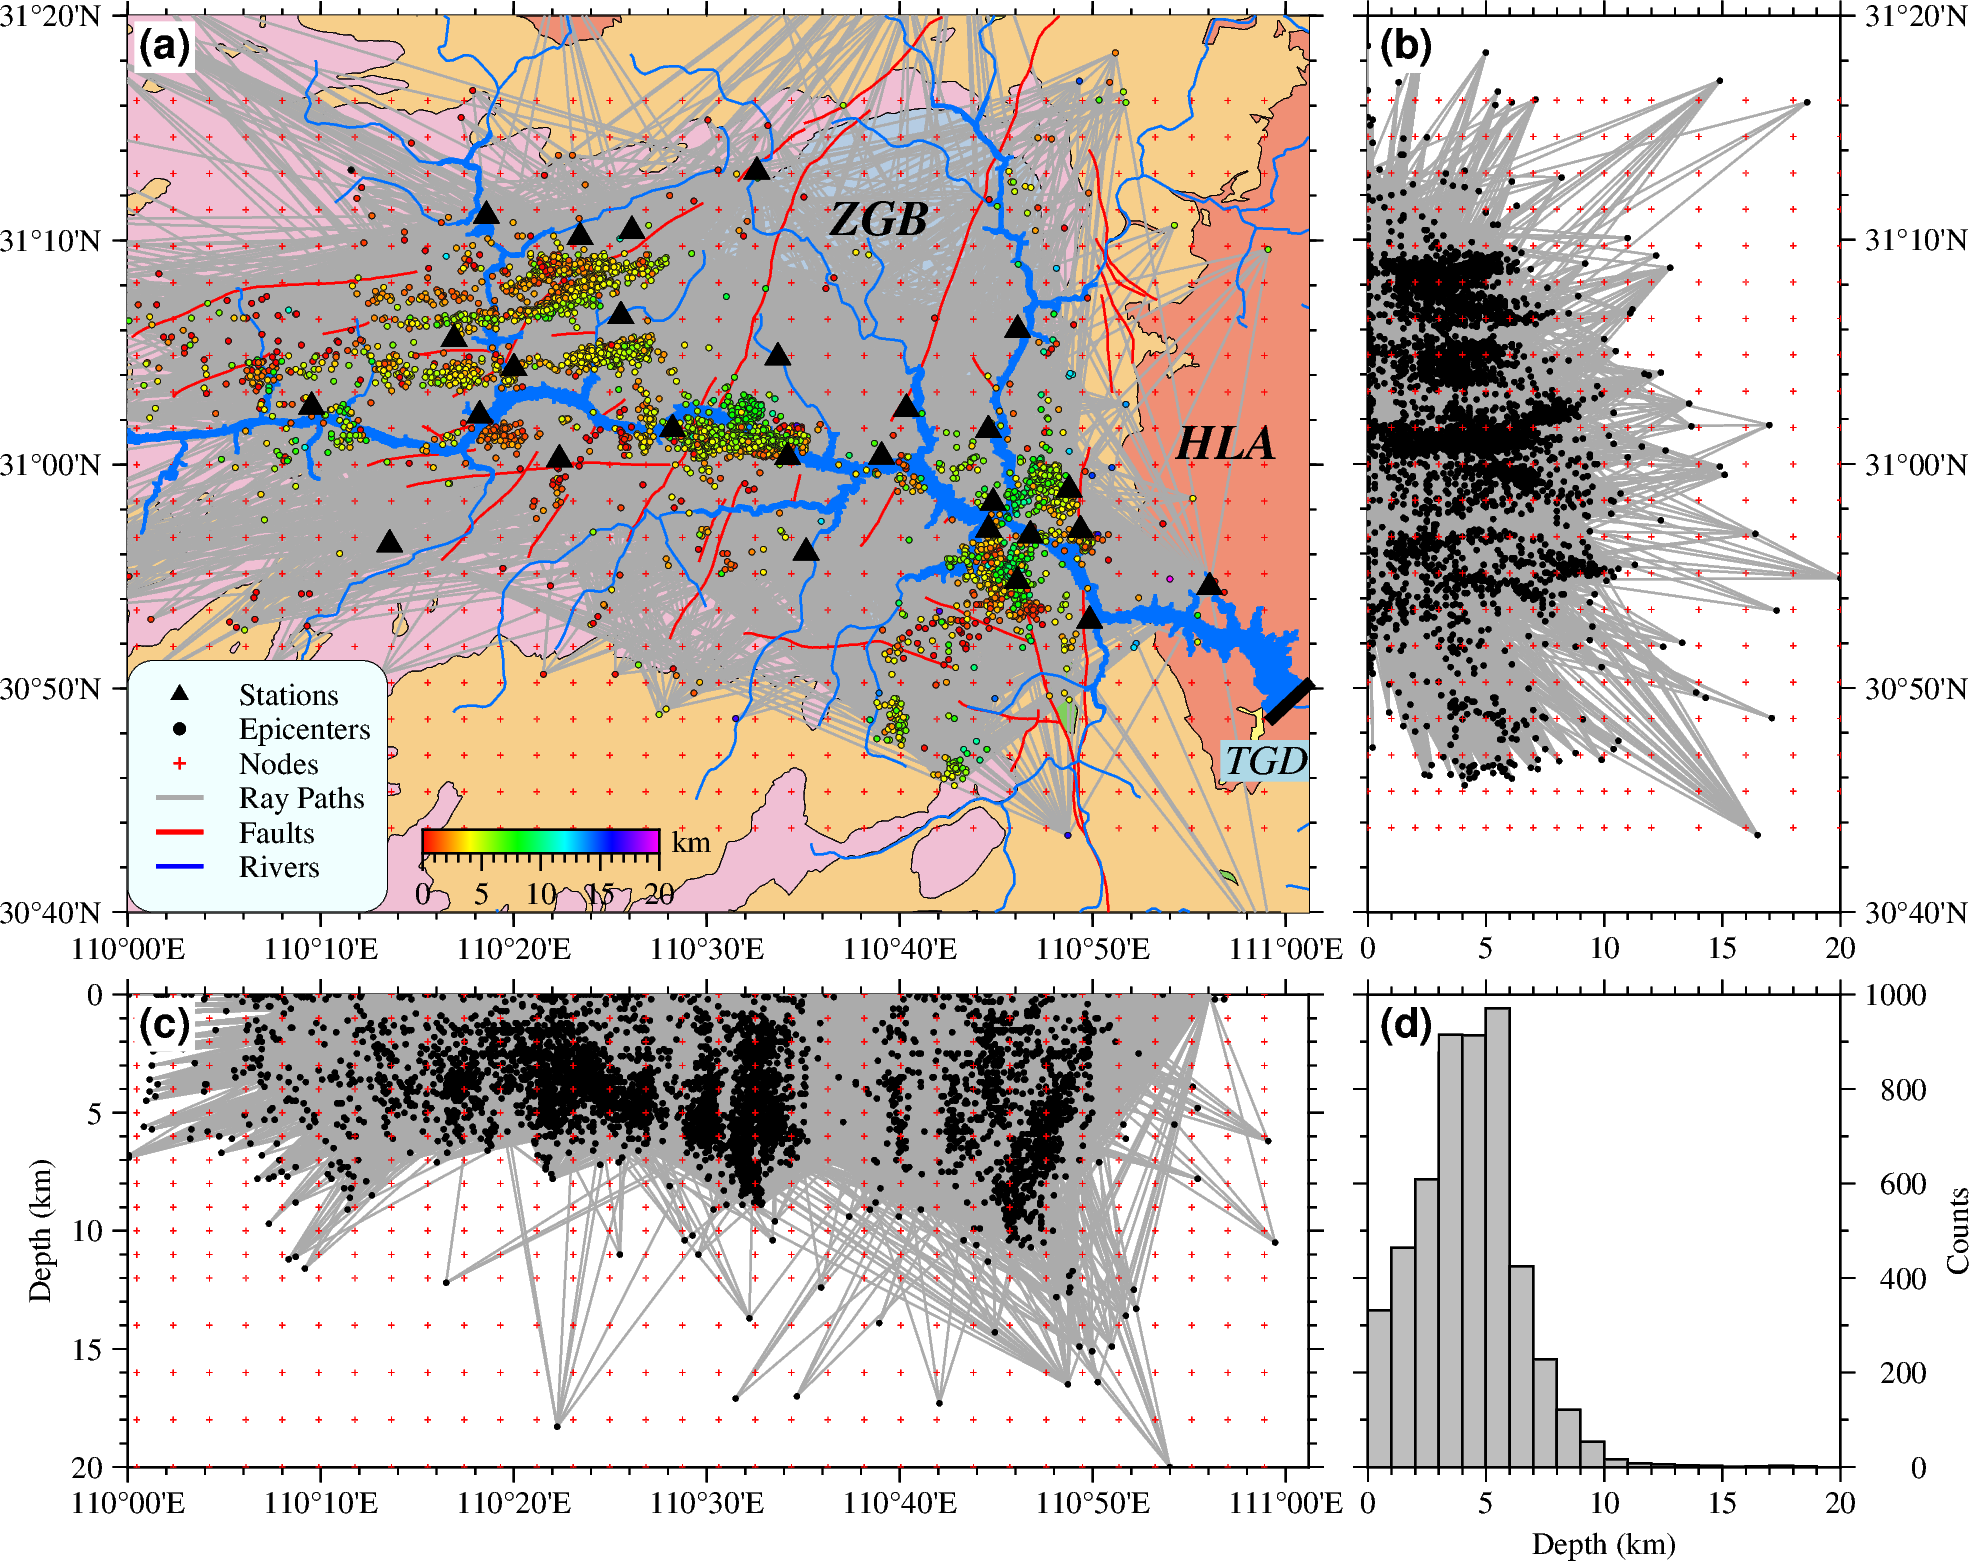

In [11]:
# hist
fig.shift_origin(xshift='10.5c')
fig.histogram(data=catalog_df.depth,
              region=[0,20,0,0],
              projection='X4c/4c',
              frame=['xaf+lDepth (km)','ya200f100+lCounts','wSEn'],
              series=1,
              fill='gray',
              pen='0.5p',
              histtype=0)
fig.text(position='cTL',text='(d)',font='10p,1',offset='j0.1c/0.1c',fill='white')
fig.show()

In [12]:
# save
fig.savefig('plotting_figures'+os.sep+'Figure6_raypath.png',dpi=600)
fig.savefig('plotting_figures'+os.sep+'Figure6_raypath.pdf')

In [13]:
# remove data
for file in glob.glob('*.gmt'):
    os.remove(file)
